# Bluebook for Bulldozers
https://www.kaggle.com/c/bluebook-for-bulldozers

In [1]:
import sys
sys.path.insert(0, '..')
print(sys.path)

%load_ext autoreload
%autoreload 2
%matplotlib inline

['..', '', '/opt/conda/lib/python36.zip', '/opt/conda/lib/python3.6', '/opt/conda/lib/python3.6/lib-dynload', '/opt/conda/lib/python3.6/site-packages', '/opt/conda/lib/python3.6/site-packages/Mako-1.0.7-py3.6.egg', '/opt/conda/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg', '/opt/conda/lib/python3.6/site-packages/IPython/extensions', '/home/jovyan/.ipython']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = "../data/bluebook-for-bulldozers/"

# Exploring the Data

In [4]:
train_data = pd.read_csv(f'{path}Train.csv', low_memory=False, parse_dates=["saledate"])

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [6]:
display_all(train_data.head().transpose())

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [7]:
train_data.SalePrice = np.log(train_data.SalePrice)

# Creating the Random Forest Regressor

In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1)

In [9]:
predictors = train_data.drop('SalePrice', axis=1)

In [10]:
model.fit(predictors, train_data.SalePrice)

ValueError: could not convert string to float: 'Conventional'

This error occurs because this dataset contains a mix of *continuous* and *categorical* variables. We need to first process the data.

# Data Cleaning

To make sure everything works, we need to clean up all continuous variables into categorical variables.

In [12]:
from utils.structured import add_datepart, train_cats, proc_df

## Feature Engineering with Dates

First, we split the date string into potentially useful features.

In [13]:
add_datepart(train_data, 'saledate')

In [15]:
train_data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


This is not enough, there are still variables that are strings, and need to be categorical:

In [16]:
from utils.structured import train_cats

train_cats(train_data)

We can specify the order of the categories:

In [17]:
train_data.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [18]:
train_data.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Still, we are not done: there are a lot of missing values, which we can't pass to the Random Forest directly:

In [19]:
display_all(train_data.isnull().sum().sort_index()/len(train_data))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

Let's save the dataframe into disk for now.

In [21]:
import os

os.makedirs('tmp', exist_ok=True)
train_data.to_feather('tmp/bulldozers') #to_feather would be faster

In [24]:
train_data = pd.read_feather('tmp/bulldozers')

In [26]:
display_all(train_data.head())

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3,204,False,False,False,False,False,False,1248307200


In [27]:
from utils.structured import proc_df

In [33]:
df, y, nas = proc_df(train_data, 'SalePrice')

In [34]:
model.fit(df, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [36]:
model.score(df, y)

0.9830210853525474

This really high r^2 value is not representative of the model's accuracy, given that it is measuring the against the data set it is learning from.

In [42]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(df, y, test_size=0.2, random_state=42)

In [47]:
train_X.size

21179400

In [48]:
val_X.size

5294850

In [49]:
model.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [50]:
model.score(val_X, val_y)

0.9006403112689001

# Bagging

In [51]:
preds = np.stack([t.predict(val_X) for t in model.estimators_])
preds[:,0], np.mean(preds[:,0]), val_y[0]

(array([ 10.32548196,  10.27505111,  10.27505111,  10.27505111,
         10.37349118,  10.16585182,  10.37349118,   9.87816974,
          9.99879773,  10.16585182]), 10.210628876396459, 10.46310334047155)

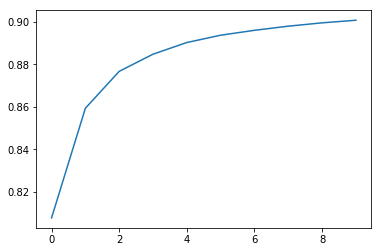

In [55]:
import sklearn.metrics as metrics
plt.plot([metrics.r2_score(val_y, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much.

## Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our print_score function below.


In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(train_X, train_y)

In [ ]:
m.score(val_X, val_y)

# Reducing Overfitting

one can do this via:

1. Subsampling
2. Altering Tree building parameters (like depth of tree)